**@author Güise Rodríguez**

**Execution date: 14/04/2019 21:00 **

# Instalo las librerías necesarias

In [1]:
!pip3 install requests
!pip3 install beautifulsoup4


# Importo las librerías necesarias

In [0]:
import requests, sys, re, csv, urllib.robotparser
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# It's show time!

## Preparación para el Scraping

### Modifico el user-agent para evitar bloqueos


In [0]:
headers = {
"Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,\ */*;q=0.8",
"Accept-Encoding": "gzip, deflate, sdch, br",
"Accept-Language": "en-US,en;q=0.8",
"Cache-Control": "no-cache", "dnt": "1",
"Pragma": "no-cache",
"Upgrade-Insecure-Requests": "1",
"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3) AppleWebKit/5\ 37.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36" }

### Verifico el  fichero robots.txt

Para verificar que el fichero robots.txt no evita que podamos consultar las páginas con noticias que nos interesan, creamos una instancia del objeto de Python **RobotFileParser**, que con cuya función **can_fetch()** nos permite conocer devolviendo un booleano si este fichero indica o no si se puede rastrear dicho directorio.

In [4]:
rp = urllib.robotparser.RobotFileParser()
rp.set_url("https://www.eldiario.es/robots.txt")
rp.read()
rp.can_fetch("*", "https://www.eldiario.es/focos/")

True

In [5]:
request = requests.get("https://www.eldiario.es/robots.txt", headers=headers)
if request.status_code != 200:
  sys.exit("Error Code: " + str(request.status_code))
soup = BeautifulSoup(request.content)
print(soup.find('p').prettify())

<p>
 User-agent: *
Disallow: /bbtcaptcha/
Disallow: /bbtcomment/create/
Disallow: /bbtcomment/vote/
Disallow: /bbtcomment/report/
Disallow: /bbtcomment/entityComments/
Disallow: /bbtcontent/poll/vote/
Disallow: /bbtcontent/poll/getresults/
Disallow: /props/
Disallow: https://www.eldiario.es/economia/Grupo-Asfi-apropiacion-indebida-blanqueo_0_73143178.html
Disallow: https://www.eldiario.es/norte/navarra/ultima_hora/Condenado-prision-Inaki-Gil-Asfi_0_363614222.html
Disallow: https://www.eldiario.es/norte/navarra/ultima_hora/vale-millon-euros-carcel-llevo_0_353815044.html
Disallow: https://www.eldiario.es/economia/juezas-pagadas-Indra-sentencias-empresa_0_359764337.html
Disallow: https://www.eldiario.es/canariasahora/topsecret/Mckenzie-ataca-nuevo_6_97350295.html
Disallow: /bbtmail/sendEntity/
Disallow: /bbtshop/
Disallow: /bbtstats/
Disallow: /logout.html

Sitemap: https://www.eldiario.es/sitemap_index.xml
Sitemap: https://www.eldiario.es/sitemap_google_news.xml
</p>


También realizo la comprobación imprimiendo los datos del fichero robots.txt para comprobar nuevamente que la página permite rastrear el directorio seleccionado.

Observamos cómo entre los directorios prohibidos a todos los robots no se encuentra **/focos**.

## Código Principal




In [0]:
# Defino las variables que permitirán extraer la información de 5 secciones del periódico digital junto a su profundidad máxima.
base = "https://www.eldiario.es/focos/"
focos = ['mejores_ciudades','vida_digital','creacion_cultural','medio_ambiente','maltrato_animal']
depth = [12,23,41,37,10]
header = ['headline','type','date','section','author','authorInfo','location','url']
csvData = []

In [0]:
def get_author(extract):
  """
  Función que busca todas las etiquetas 'a' que contienen los nombres de los 
  autores/as del contenido y las concatena separadas por comas.
  En caso de no haber información en este campo, se adquiere la información del
  primer contenido del extracto HTML, limpiándose los saltos de línea, guiones y 
  varios espacios seguidos que suelen tener los nombres de colectivos autores.
  """
  authors = []
  for autora in extract.find_all("a"):
    authors.append(re.sub(' +',' ',autora['title']))
  if authors:
    return ",".join(map(str,authors))
  #Si es un colectivo, el nombre aparecería con dicho formato
  return re.sub(' +',' ',re.sub('-','',re.sub('\n','',extract.contents[0]))).strip()

In [0]:
def get_data(extract):
  """
  Función que busca la clase asociada a los artículos de opinión
  en las clases del código HTML y determina así si la información
  contenida en la etiqueta 'span' con clase 'location' (si existiera)
  es información extra sobre el autor o la localización de la noticia. 
  """
  extra = extract.find("span",{"class": "location"})
  if 'lst-item-opinion' in extract.get("class"):
    type = "opinion"
    if extra:
      authorInfo = extra.getText()
      location = ""
  else:
    type = "news"
    if extra:
      authorInfo = ""
      location = extra.getText()
  if extra is None:
    authorInfo = ""
    location = ""
  return type, authorInfo, location

In [0]:
def save_dataset(csvData, header):
  """
  Función que convierte la lista de listas csvData a Dataframe y la guarda en un csv
  utilizando las funciones de la librería Pandas.
  """
  dfObj = pd.DataFrame(csvData, columns= header)
  dfObj.to_csv("eldiario_news.csv",sep=";",index=False,quoting=csv.QUOTE_MINIMAL)
  return dfObj

In [0]:
def get_page(i, foco):
  """
  Función que recorre todas las páginas que tiene la sección 'foco',
  descarga la página comprobando posibles errores en la solicitud y
  pasa a la función 'get_noticia()' los datos contenidos en la etiqueta
  'div' con clase 'pg-body', que contiene las noticias del medio.
  """
  for nPage in np.arange(depth[i])+1:
    target = base + foco + "/?page=" + str(nPage) 
    request = requests.get(target, headers=headers)
    if request.status_code != 200:
      sys.exit("Error Code: " + str(request.status_code))
    soup = BeautifulSoup(request.content)
    body = soup.find("div",{"class": "pg-body"})
    get_noticia(body) 

In [0]:
def get_noticia(body):
  """
  Función que recorre las diferentes noticias, buscando las diferentes
  etiquetas 'li' con clase 'lst-item' en las que están contenidas, 
  y obtiene datos como el tipo de noticia y la información opcional
  como información extra del autor o la localización de la noticia llamando
  a la función 'get_data()', el título extrayendo el atributo 'title' de la
  etiqueta 'a', la fecha de publicación de la etiqueta 'span' con clase
  'date', la url relativa del atributo 'href' de la etiqueta 'a' y el autor
  o autores llamando a la función 'get_author()'. Por último, concatena a la lista
  csvData una lista con todos los datos de cada noticia.
  """
  for noticia in body.find_all("li",{"class": "lst-item"}):
        type, authorInfo, location = get_data(noticia)
        datos = noticia.find("span",{"class": "byline"})
        headline = re.sub("\\\\'","\'",noticia.find("a")['title']) #Sustituyo "\\'" por una comilla simple
        date = datos.find("span",{"class": "date"}).getText()
        author = get_author(datos)
        url = "eldiario.es" + noticia.find("a")['href']
        csvData.append([headline,type,date,foco,author,authorInfo,location,url])

In [0]:
"""
Código principal en el que se iteran las diferentes secciones
'focos' y se le pasa junto a su identificador numérico para
que la función 'get_page()' itere todas sus páginas.
Posteriormente llama a la función 'save_dataset' para que 
guarde todas las noticias en un fichero csv.
"""
for i, foco in enumerate(focos):
    get_page(i, foco)
csvData = save_dataset(csvData, header)

## Representación gráfica del dataset

In [13]:
csvData.head()

,headline,type,date,section,author,authorInfo,location,url
0,Francia experimentará durante cinco años la li...,news,10/04/2019,mejores_ciudades,Marina Estévez Torreblanca,,,eldiario.es/economia/Francia-experimentara-lim...
1,"""El cambio de uso de la ciudad nos lleva a con...",opinion,09/04/2019,mejores_ciudades,Pedro Bravo,,,eldiario.es/desde-mi-bici/llevado-considerar-v...
2,El domingo sal a la calle a pedir un carril bi...,opinion,05/04/2019,mejores_ciudades,Plataforma por un Carril Bici en la Castellana,,,eldiario.es/tribunaabierta/domingo-calle-pedir...
3,"La acera par de Gran Vía, el punto más calient...",news,01/04/2019,mejores_ciudades,"Analía Plaza,Ana Ordaz",,,eldiario.es/madrid/lado-Gran-Via-caro-impar_0_...
4,La ciudadanía impulsa el 'car sharing',opinion,27/03/2019,mejores_ciudades,Mariana Vilnitzky,,,eldiario.es/alternativaseconomicas/ciudadania-...


En primer lugar, creamos un nuevo dataframe que contenga la fecha de publicación y la sección en la que fue publicada.

Después extraemos de la fecha el mes y año. Posteriormente usaremos el campo original 'date' para agrupar todas las publicaciones.

**El objetivo final es conocer, por cada mes y año, el nº de publicaciones por cada sección.**

In [0]:
news_reduced = csvData.filter(items=['section','date'])

In [0]:
news_reduced['month'] = pd.DatetimeIndex(csvData['date'], dayfirst=True).month
news_reduced['year'] = pd.DatetimeIndex(csvData['date'], dayfirst=True).year

In [16]:
news_reduced.shape

(3622, 4)

A continuación, agrupamos los 3622 registros obtenidos por año, mes y  sección.

Para ello llevar a cabo este proceso de agregación usaremos la función **groupby** de Pandas indicándole los 3 campos por los que queremos agrupar. Después usaremos la función **count()** para que nos devuelva en el campo date (utilizado como contador) el nº de publicaciones por mes, año y sección.

El uso de las funciones **unstack** (indicando con level el índice que queremos utilizar en cada momento) y la función **stack** nos permite llenar con 0 aquellos meses y años en las que no tenemos ningún valor para cada sección.

In [17]:
#Primero agrupamos por año
news_reduced_year = news_reduced.groupby(['year','month','section']).count().unstack(level=-3,fill_value=0)[['date']]
news_reduced_year

date                         
year                    2014 2015 2016 2017 2018 2019
month section                                        
1     creacion_cultural    0    0    0   36   36   47
      maltrato_animal      0    0    0    6   11   12
      medio_ambiente       0    0    0   11   41   43
      mejores_ciudades     0    0    0    5    9    7
      vida_digital         0    0    0   20   18   17
2     creacion_cultural    0    0    0   18   31   36
      maltrato_animal      0    0    0    9   10    4
      medio_ambiente       0    0    1   23   33   43
      mejores_ciudades     0    0    0    9    7   10
      vida_digital         0    0    0   18   17   15
3     creacion_cultural    0    0    0   36   40   41
      maltrato_animal      0    0    0   13   11    7
      medio_ambiente       0    0    0   29   45   65
      mejores_ciudades     0    0    0    8    9   12
      vida_digital         0    0    0   22   14   20
4     creacion_cultural    0    0    0   33   35   33
      maltrato_animal      0    0    0    3   16    3
      medio_ambiente       0    0    0   17   32   24
      mejores_ciudades     0    0    0    6    6    4
      vida_digital         0    0    0   23   13   13
5     creacion_cultural    0    0    0   50   50    0
      maltrato_animal      0    0    1   12   16    0
      medio_ambiente       0    0    0   28   26    0
      mejores_ciudades     0    0    1   11   18    0
      vida_digital         0    0    0   22   10    0
6     creacion_cultural    0    0    0   45   48    0
      maltrato_animal      0    0    0   10   15    0
      medio_ambiente       0    0    1   53   44    0
      mejores_ciudades     0    0    0   11   17    0
      vida_digital         0    0    0   34   10    0
7     creacion_cultural    0    0    0   46   53    0
      maltrato_animal      0    0    2   10    7    0
      medio_ambiente       0    0    2   37   36    0
      mejores_ciudades     0    0    0   13   10    0
      vida_digital         0    0    0   29   24    0
8     creacion_cultural    0    0    2   41   52    0
      maltrato_animal      0    0    0    9    7    0
      medio_ambiente       0    0    1   21   31    0
      mejores_ciudades     0    0    0    7   11    0
      vida_digital         0    0    2   30   13    0
9     creacion_cultural    0    0   17   30   38    0
      maltrato_animal      0    1    3   13    4    0
      medio_ambiente       0    0    3   37   33    0
      mejores_ciudades     1    0    3    7   17    0
      vida_digital         0    0   12   37   23    0
10    creacion_cultural    0    0   38   43   39    0
      maltrato_animal      0    0    7    9    7    0
      medio_ambiente       0    0   12   57   56    0
      mejores_ciudades     0    0   10    7   28    0
      vida_digital         0    0   22   30   38    0
11    creacion_cultural    0    0   49   33   43    0
      maltrato_animal      0    0    3   16   14    0
      medio_ambiente       0    0   12   41   60    0
      mejores_ciudades     0    1    2   11   21    0
      vida_digital         0    0   19   23   29    0
12    creacion_cultural    0    0   14   34   38    0
      maltrato_animal      0    1    2    5   11    0
      medio_ambiente       0    0    8   32   58    0
      mejores_ciudades     0    0   11   11   18    0
      vida_digital         0    0    6   24   25    0

In [18]:
news_reduced_year = news_reduced_year.stack()
news_reduced_year

date
month section           year      
1     creacion_cultural 2014     0
                        2015     0
                        2016     0
                        2017    36
                        2018    36
                        2019    47
      maltrato_animal   2014     0
                        2015     0
                        2016     0
                        2017     6
                        2018    11
                        2019    12
      medio_ambiente    2014     0
                        2015     0
                        2016     0
                        2017    11
                        2018    41
                        2019    43
      mejores_ciudades  2014     0
                        2015     0
                        2016     0
                        2017     5
                        2018     9
                        2019     7
      vida_digital      2014     0
                        2015     0
                        2016     0
                        2017    20
                        2018    18
                        2019    17
...                            ...
12    creacion_cultural 2014     0
                        2015     0
                        2016    14
                        2017    34
                        2018    38
                        2019     0
      maltrato_animal   2014     0
                        2015     1
                        2016     2
                        2017     5
                        2018    11
                        2019     0
      medio_ambiente    2014     0
                        2015     0
                        2016     8
                        2017    32
                        2018    58
                        2019     0
      mejores_ciudades  2014     0
                        2015     0
                        2016    11
                        2017    11
                        2018    18
                        2019     0
      vida_digital      2014     0
                        2015     0
                        2016     6
                        2017    24
                        2018    25
                        2019     0

[360 rows x 1 columns]

In [19]:
#Después agrupamos por mes
news_reduced_year_month = news_reduced_year.groupby(['year','month','section']).sum().unstack(level=-2,fill_value=0)[['date']]
news_reduced_year_month

date                                            
month                    1   2   3   4   5   6   7   8   9   10  11  12
year section                                                           
2014 creacion_cultural    0   0   0   0   0   0   0   0   0   0   0   0
     maltrato_animal      0   0   0   0   0   0   0   0   0   0   0   0
     medio_ambiente       0   0   0   0   0   0   0   0   0   0   0   0
     mejores_ciudades     0   0   0   0   0   0   0   0   1   0   0   0
     vida_digital         0   0   0   0   0   0   0   0   0   0   0   0
2015 creacion_cultural    0   0   0   0   0   0   0   0   0   0   0   0
     maltrato_animal      0   0   0   0   0   0   0   0   1   0   0   1
     medio_ambiente       0   0   0   0   0   0   0   0   0   0   0   0
     mejores_ciudades     0   0   0   0   0   0   0   0   0   0   1   0
     vida_digital         0   0   0   0   0   0   0   0   0   0   0   0
2016 creacion_cultural    0   0   0   0   0   0   0   2  17  38  49  14
     maltrato_animal      0   0   0   0   1   0   2   0   3   7   3   2
     medio_ambiente       0   1   0   0   0   1   2   1   3  12  12   8
     mejores_ciudades     0   0   0   0   1   0   0   0   3  10   2  11
     vida_digital         0   0   0   0   0   0   0   2  12  22  19   6
2017 creacion_cultural   36  18  36  33  50  45  46  41  30  43  33  34
     maltrato_animal      6   9  13   3  12  10  10   9  13   9  16   5
     medio_ambiente      11  23  29  17  28  53  37  21  37  57  41  32
     mejores_ciudades     5   9   8   6  11  11  13   7   7   7  11  11
     vida_digital        20  18  22  23  22  34  29  30  37  30  23  24
2018 creacion_cultural   36  31  40  35  50  48  53  52  38  39  43  38
     maltrato_animal     11  10  11  16  16  15   7   7   4   7  14  11
     medio_ambiente      41  33  45  32  26  44  36  31  33  56  60  58
     mejores_ciudades     9   7   9   6  18  17  10  11  17  28  21  18
     vida_digital        18  17  14  13  10  10  24  13  23  38  29  25
2019 creacion_cultural   47  36  41  33   0   0   0   0   0   0   0   0
     maltrato_animal     12   4   7   3   0   0   0   0   0   0   0   0
     medio_ambiente      43  43  65  24   0   0   0   0   0   0   0   0
     mejores_ciudades     7  10  12   4   0   0   0   0   0   0   0   0
     vida_digital        17  15  20  13   0   0   0   0   0   0   0   0

In [20]:
news_reduced_year_month = news_reduced_year_month.stack()
news_reduced_year_month

date
year section           month      
2014 creacion_cultural 1         0
                       2         0
                       3         0
                       4         0
                       5         0
                       6         0
                       7         0
                       8         0
                       9         0
                       10        0
                       11        0
                       12        0
     maltrato_animal   1         0
                       2         0
                       3         0
                       4         0
                       5         0
                       6         0
                       7         0
                       8         0
                       9         0
                       10        0
                       11        0
                       12        0
     medio_ambiente    1         0
                       2         0
                       3         0
                       4         0
                       5         0
                       6         0
...                            ...
2019 medio_ambiente    7         0
                       8         0
                       9         0
                       10        0
                       11        0
                       12        0
     mejores_ciudades  1         7
                       2        10
                       3        12
                       4         4
                       5         0
                       6         0
                       7         0
                       8         0
                       9         0
                       10        0
                       11        0
                       12        0
     vida_digital      1        17
                       2        15
                       3        20
                       4        13
                       5         0
                       6         0
                       7         0
                       8         0
                       9         0
                       10        0
                       11        0
                       12        0

[360 rows x 1 columns]

In [21]:
#Por último, agrupamos por sección
news_reduced_year_month_section = news_reduced_year_month.groupby(['year','month','section']).sum().unstack(level=-1,fill_value=0)[['date']]
news_reduced_year_month_section

date                                                  \
section    creacion_cultural maltrato_animal medio_ambiente mejores_ciudades   
year month                                                                     
2014 1                     0               0              0                0   
     2                     0               0              0                0   
     3                     0               0              0                0   
     4                     0               0              0                0   
     5                     0               0              0                0   
     6                     0               0              0                0   
     7                     0               0              0                0   
     8                     0               0              0                0   
     9                     0               0              0                1   
     10                    0               0              0                0   
     11                    0               0              0                0   
     12                    0               0              0                0   
2015 1                     0               0              0                0   
     2                     0               0              0                0   
     3                     0               0              0                0   
     4                     0               0              0                0   
     5                     0               0              0                0   
     6                     0               0              0                0   
     7                     0               0              0                0   
     8                     0               0              0                0   
     9                     0               1              0                0   
     10                    0               0              0                0   
     11                    0               0              0                1   
     12                    0               1              0                0   
2016 1                     0               0              0                0   
     2                     0               0              1                0   
     3                     0               0              0                0   
     4                     0               0              0                0   
     5                     0               1              0                1   
     6                     0               0              1                0   
...                      ...             ...            ...              ...   
2017 7                    46              10             37               13   
     8                    41               9             21                7   
     9                    30              13             37                7   
     10                   43               9             57                7   
     11                   33              16             41               11   
     12                   34               5             32               11   
2018 1                    36              11             41                9   
     2                    31              10             33                7   
     3                    40              11             45                9   
     4                    35              16             32                6   
     5                    50              16             26               18   
     6                    48              15             44               17   
     7                    53               7             36               10   
     8                    52               7             31               11   
     9                    38               4             33               17   
     10                   39               7             56               28   
     11                 

In [22]:
news_reduced_year_month_section = news_reduced_year_month_section.stack()
news_reduced_year_month_section

date
year month section                
2014 1     creacion_cultural     0
           maltrato_animal       0
           medio_ambiente        0
           mejores_ciudades      0
           vida_digital          0
     2     creacion_cultural     0
           maltrato_animal       0
           medio_ambiente        0
           mejores_ciudades      0
           vida_digital          0
     3     creacion_cultural     0
           maltrato_animal       0
           medio_ambiente        0
           mejores_ciudades      0
           vida_digital          0
     4     creacion_cultural     0
           maltrato_animal       0
           medio_ambiente        0
           mejores_ciudades      0
           vida_digital          0
     5     creacion_cultural     0
           maltrato_animal       0
           medio_ambiente        0
           mejores_ciudades      0
           vida_digital          0
     6     creacion_cultural     0
           maltrato_animal       0
           medio_ambiente        0
           mejores_ciudades      0
           vida_digital          0
...                            ...
2019 7     creacion_cultural     0
           maltrato_animal       0
           medio_ambiente        0
           mejores_ciudades      0
           vida_digital          0
     8     creacion_cultural     0
           maltrato_animal       0
           medio_ambiente        0
           mejores_ciudades      0
           vida_digital          0
     9     creacion_cultural     0
           maltrato_animal       0
           medio_ambiente        0
           mejores_ciudades      0
           vida_digital          0
     10    creacion_cultural     0
           maltrato_animal       0
           medio_ambiente        0
           mejores_ciudades      0
           vida_digital          0
     11    creacion_cultural     0
           maltrato_animal       0
           medio_ambiente        0
           mejores_ciudades      0
           vida_digital          0
     12    creacion_cultural     0
           maltrato_animal       0
           medio_ambiente        0
           mejores_ciudades      0
           vida_digital          0

[360 rows x 1 columns]

Debido a que las funciones **stack()** y **unstack()**  generan datos para todos los años y meses teniendo en cuenta todos los valores únicos que contienen en las dos columnas, se crean registros para los meses futuros de 2019. 

Para arreglarlo filtraremos aquellos registros que **NO** cumplan las condiciones de ser del año 2019 y un mes superior al 4 (abril).

Lo mismo ocurre con los meses previos a septiembre de 2014. Para arreglarlo filtraremos aquellos registros que **NO** cumplan las condiciones de ser del año 2014 y un mes inferior al 9 (septiembre).

In [0]:
news_group = news_reduced_year_month_section.copy()
news_group_filter  = news_group[~((news_group.index.get_level_values('year') == 2019) & (news_group.index.get_level_values('month') > 4))]
news_group_filter  = news_group_filter[~((news_group_filter.index.get_level_values('year') == 2014) & (news_group_filter.index.get_level_values('month') < 9))]

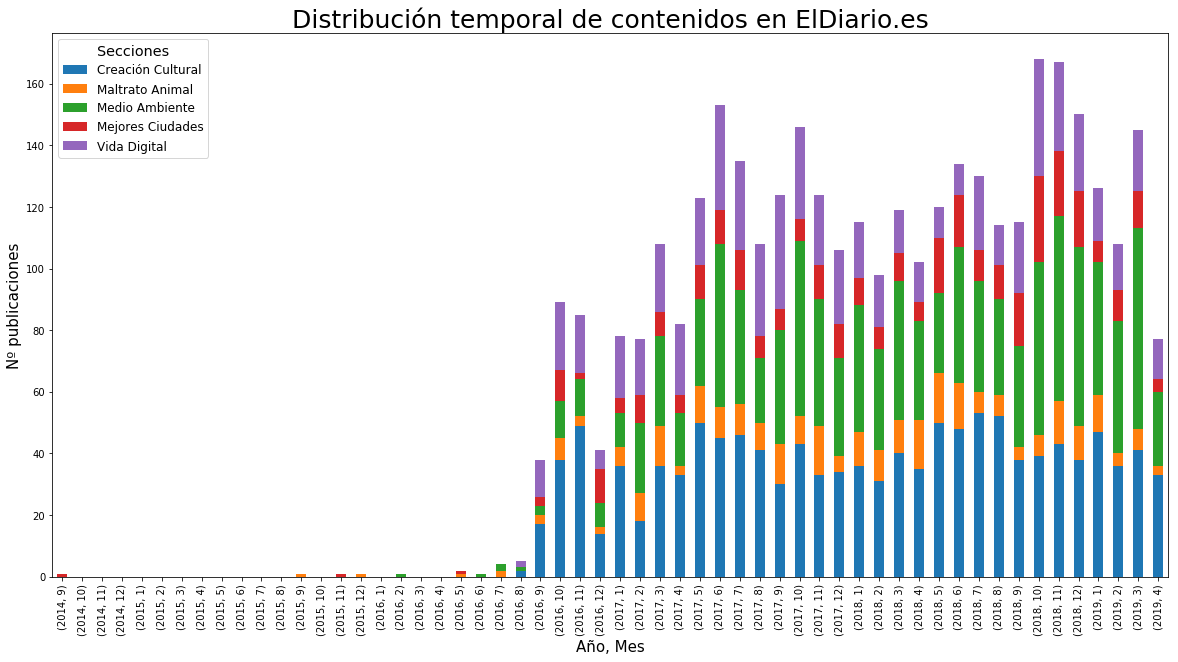

In [24]:
fig, ax = plt.subplots()
news_group_filter.unstack().plot(kind='bar', stacked=True, figsize=(20,10), ax=ax)
plt.xlabel("Año, Mes", fontsize=15)
plt.ylabel("Nº publicaciones", fontsize=15)
plt.title("Distribución temporal de contenidos en ElDiario.es", fontsize=25)
ax.legend(["Creación Cultural", "Maltrato Animal", "Medio Ambiente", "Mejores Ciudades", "Vida Digital"], 
          title="Secciones", prop={'size': 12}, title_fontsize='x-large')

Como podemos observar en la gráfica, no fue hasta el mes de septiembre de 2016 cuando el periódico empezó a publicar contenidos de una manera abundante en estas 5 secciones.

In [0]:
# Guardamos la figura en un png.
fig.savefig('distribution_eldiario_news.png')